In [7]:
import numpy as np
import pandas as pd
data_df = pd.read_excel('carbon_data.xlsx', header=4)

In [ ]:
# Printing current column names
data_df.columns

In [ ]:
# Dropping the specified columns from the DataFrame
cleaned_df = data_df.drop(['Percent', 'Absolute', 'Percent.1', 'Absolute.1'], axis=1)

In [ ]:
cleaned_df.columns

In [ ]:
# Set State as the index and transpose the DataFrame
final_transposed_df = cleaned_df.set_index('State').transpose()

# Reset index to turn years into a column and rename it
final_transposed_df.reset_index(inplace=True)
final_transposed_df.rename(columns={'index': 'Year'}, inplace=True)

final_transposed_df.head()

In [ ]:
# Print the number of NaNs in each column
print(final_transposed_df.isna().sum())

In [ ]:
# Dropping the specified columns from the DataFrame
final_transposed_df = final_transposed_df.drop(columns=['Total of states', 'Sources:  U.S. Energy Information Administration (EIA), State Energy Data System and EIA calculations made for this table.'])

print(final_transposed_df.head())

In [ ]:
final_transposed_df = final_transposed_df.iloc[:, :-1]

In [ ]:
final_transposed_df

In [ ]:
t1_norm= final_transposed_df
t1_norm

In [ ]:
t1_norm

####Linear regression

In [ ]:
pip install codecarbon

In [2]:
from codecarbon import EmissionsTracker

# Initialize the emissions tracker
tracker = EmissionsTracker()

# Start tracking
tracker.start()

[codecarbon WARNING @ 00:51:22] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 00:51:22] [setup] RAM Tracking...
[codecarbon INFO @ 00:51:22] [setup] GPU Tracking...
[codecarbon INFO @ 00:51:22] No GPU found.
[codecarbon INFO @ 00:51:22] [setup] CPU Tracking...
[codecarbon WARNING @ 00:51:22] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 00:51:24] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 00:51:24] >>> Tracker's metadata:
[codecarbon INFO @ 00:51:24]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 00:51:24]   Python version: 3.10.12
[codecarbon INFO @ 00:51:24]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 00:51:24]   Available RAM : 12.675 GB
[codecarbon INFO @ 00:51:24]   CPU count: 2
[codecarbon INFO @ 00:51:24]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 00:51:24]   GPU count: None
[codecarbon INFO @ 00:51:24]   GPU model

In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

train_df = t1_norm[t1_norm['Year'] <= 2015]
test_df = t1_norm[t1_norm['Year'] >= 2016]

n_states = train_df.drop(columns=['Year']).shape[1] 
X_train_norm = np.repeat(train_df[['Year']].values, n_states, axis=0)  
X_test_norm = np.repeat(test_df[['Year']].values, n_states, axis=0)

# Concatenate all state columns into a single array for training and testing
y_train_norm = train_df.drop(columns=['Year']).values.flatten()
y_test_norm = test_df.drop(columns=['Year']).values.flatten()

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train_norm, y_train_norm)

# Predict using the model
predictions = model.predict(X_test_norm)

# Calculate MSE, RMSE, MAE, and R2 for all states combined
mse = mean_squared_error(y_test_norm, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_norm, predictions)
r2 = r2_score(y_test_norm, predictions)

# Print the aggregated metrics
print(f"Aggregated MAE: {mae}")
print(f"Aggregated MSE: {mse}")
#print(f"Aggregated RMSE: {rmse}")
print(f"Aggregated R2: {r2}")

Aggregated MAE: 0.34798931740213374
Aggregated MSE: 0.18655448021261828
Aggregated R2: -1.4469503626778537


####LSTM

In [56]:
# LSTM with normalization & 50 epoch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

train_df = t1_norm[t1_norm['Year'] <= 2015]
test_df = t1_norm[t1_norm['Year'] >= 2016]

# Normalize the features
scaler = MinMaxScaler()
features = train_df.columns.difference(['Year'])  # All columns except 'Year'
train_features = scaler.fit_transform(train_df[features])
test_features = scaler.transform(test_df[features])

# Reshape for LSTM [samples, timesteps, features]
X_train = train_features.reshape((train_features.shape[0], 1, len(features)))
X_test = test_features.reshape((test_features.shape[0], 1, len(features)))

y_train = train_df[features].values
y_test = test_df[features].values

# Build and compile the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, len(features))),
    Dense(len(features))
])
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
predictions = model.predict(X_test).reshape(y_test.shape) 

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test.flatten(), predictions.flatten())

print(f"Aggregated MAE: {mae}")
print(f"Aggregated MSE: {mse}")
#print(f"Aggregated RMSE: {rmse}")
print(f"Aggregated R2: {r2}")

Epoch 1/50
2/2 [==============================] - 1s 10ms/step - loss: 20640.8633
Epoch 2/50
2/2 [==============================] - 0s 9ms/step - loss: 20593.2812
Epoch 3/50
2/2 [==============================] - 0s 9ms/step - loss: 20478.7695
Epoch 4/50
2/2 [==============================] - 0s 9ms/step - loss: 20269.4492
Epoch 5/50
2/2 [==============================] - 0s 9ms/step - loss: 19940.8359
Epoch 6/50
2/2 [==============================] - 0s 9ms/step - loss: 19494.5332
Epoch 7/50
2/2 [==============================] - 0s 9ms/step - loss: 18958.8184
Epoch 8/50
2/2 [==============================] - 0s 9ms/step - loss: 18316.0449
Epoch 9/50
2/2 [==============================] - 0s 10ms/step - loss: 17569.3750
Epoch 10/50
2/2 [==============================] - 0s 9ms/step - loss: 16743.3242
Epoch 11/50
2/2 [==============================] - 0s 8ms/step - loss: 15849.9824
Epoch 12/50
2/2 [==============================] - 0s 9ms/step - loss: 14875.1846
Epoch 13/50
2/2 [======

In [57]:
# LSTM without normalization & 50 epoch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

train_df = t1_norm[t1_norm['Year'] <= 2015]
test_df = t1_norm[t1_norm['Year'] >= 2016]

# # Normalize the features
# #scaler = MinMaxScaler()
# features = train_df.columns.difference(['Year'])  # All columns except 'Year'
# train_features = train_df[features]
# test_features = test_df[features]

# # Reshape for LSTM [samples, timesteps, features]
# X_train = train_features.reshape((train_features.shape[0], 1, len(features)))
# X_test = test_features.reshape((test_features.shape[0], 1, len(features)))

# # Targets should be prepared to match the [samples, features] without time steps for simplicity
# y_train = train_df[features].values
# y_test = test_df[features].values

# Build and compile the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, len(features))),
    Dense(len(features))
])
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

predictions = model.predict(X_test).reshape(y_test.shape)  # Reshape predictions to match y_test

# Calculate MSE, RMSE, MAE, and R2 for all states combined
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test.flatten(), predictions.flatten())

# Print the aggregated metrics
print(f"Aggregated MAE: {mae}")
print(f"Aggregated MSE: {mse}")
#print(f"Aggregated RMSE: {rmse}")
print(f"Aggregated R2: {r2}")

Epoch 1/100
2/2 [==============================] - 2s 10ms/step - loss: 20636.2637
Epoch 2/100
2/2 [==============================] - 0s 9ms/step - loss: 20575.1230
Epoch 3/100
2/2 [==============================] - 0s 12ms/step - loss: 20424.9570
Epoch 4/100
2/2 [==============================] - 0s 10ms/step - loss: 20164.2363
Epoch 5/100
2/2 [==============================] - 0s 8ms/step - loss: 19809.6816
Epoch 6/100
2/2 [==============================] - 0s 8ms/step - loss: 19295.1719
Epoch 7/100
2/2 [==============================] - 0s 8ms/step - loss: 18699.1719
Epoch 8/100
2/2 [==============================] - 0s 9ms/step - loss: 17999.2344
Epoch 9/100
2/2 [==============================] - 0s 10ms/step - loss: 17186.2441
Epoch 10/100
2/2 [==============================] - 0s 8ms/step - loss: 16322.9590
Epoch 11/100
2/2 [==============================] - 0s 8ms/step - loss: 15385.8096
Epoch 12/100
2/2 [==============================] - 0s 9ms/step - loss: 14391.2852
Epoch 13/

In [59]:
train_df = t1_norm[t1_norm['Year'] <= 2016]
test_df = t1_norm[t1_norm['Year'] >= 2017]

scaler = MinMaxScaler()
features = train_df.columns.difference(['Year'])  
train_features = scaler.fit_transform(train_df[features])
test_features = scaler.transform(test_df[features])

# Reshape for LSTM [samples, timesteps, features]
X_train = train_features.reshape((train_features.shape[0], 1, len(features)))
X_test = test_features.reshape((test_features.shape[0], 1, len(features)))

y_train = train_df[features].values
y_test = test_df[features].values

# Build and compile the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, len(features))),
    Dense(len(features))
])
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=150, batch_size=16, verbose=1)

# Predict using the model
predictions = model.predict(X_test).reshape(y_test.shape)  

# Calculate MSE, RMSE, MAE, and R2 for all states combined
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test.flatten(), predictions.flatten())

print(f"After Hyperparamter Tuning:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
#print(f"Aggregated RMSE: {rmse}")
print(f"R2: {r2}")

Epoch 1/150
3/3 [==============================] - 2s 6ms/step - loss: 0.3036
Epoch 2/150
3/3 [==============================] - 0s 5ms/step - loss: 0.1257
Epoch 3/150
3/3 [==============================] - 0s 5ms/step - loss: 0.0610
Epoch 4/150
3/3 [==============================] - 0s 5ms/step - loss: 0.0447
Epoch 5/150
3/3 [==============================] - 0s 6ms/step - loss: 0.0417
Epoch 6/150
3/3 [==============================] - 0s 5ms/step - loss: 0.0332
Epoch 7/150
3/3 [==============================] - 0s 7ms/step - loss: 0.0265
Epoch 8/150
3/3 [==============================] - 0s 6ms/step - loss: 0.0217
Epoch 9/150
3/3 [==============================] - 0s 9ms/step - loss: 0.0185
Epoch 10/150
3/3 [==============================] - 0s 7ms/step - loss: 0.0163
Epoch 11/150
3/3 [==============================] - 0s 6ms/step - loss: 0.0147
Epoch 12/150
3/3 [==============================] - 0s 6ms/step - loss: 0.0132
Epoch 13/150
3/3 [==============================] - 0s 7ms/st

Epoch 1/150
3/3 [==============================] - 1s 6ms/step - loss: 0.3151
Epoch 2/150
3/3 [==============================] - 0s 6ms/step - loss: 0.1226
Epoch 3/150
3/3 [==============================] - 0s 5ms/step - loss: 0.0596
Epoch 4/150
3/3 [==============================] - 0s 6ms/step - loss: 0.0444
Epoch 5/150
3/3 [==============================] - 0s 6ms/step - loss: 0.0374
Epoch 6/150
3/3 [==============================] - 0s 6ms/step - loss: 0.0335
Epoch 7/150
3/3 [==============================] - 0s 6ms/step - loss: 0.0284
Epoch 8/150
3/3 [==============================] - 0s 6ms/step - loss: 0.0223
Epoch 9/150
3/3 [==============================] - 0s 6ms/step - loss: 0.0184
Epoch 10/150
3/3 [==============================] - 0s 5ms/step - loss: 0.0161
Epoch 11/150
3/3 [==============================] - 0s 6ms/step - loss: 0.0149
Epoch 12/150
3/3 [==============================] - 0s 5ms/step - loss: 0.0142
Epoch 13/150
3/3 [==============================] - 0s 5ms/st

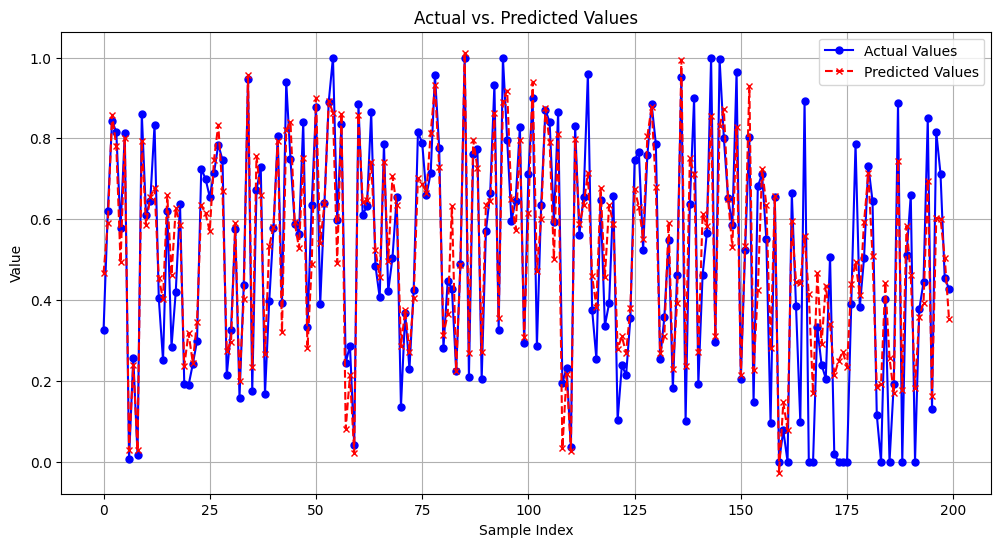

In [69]:
# Build and compile the LSTM model
import matplotlib.pyplot as plt

model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, len(features))),
    Dense(len(features))
])
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=150, batch_size=16, verbose=1)

# Predict using the model
predictions = model.predict(X_test).reshape(y_test.shape)  # Reshape predictions to match y_test

# Calculate MSE, RMSE, MAE, and R2 for all states combined
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test.flatten(), predictions.flatten())

# Print the aggregated metrics
print(f"After Hyperparamter Tuning:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
#print(f"Aggregated RMSE: {rmse}")
print(f"R2: {r2}")

# Plotting actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.flatten()[:200], label='Actual Values', marker='o', linestyle='-', markersize=5, color='blue')
plt.plot(predictions.flatten()[:200], label='Predicted Values', marker='x', linestyle='--', markersize=5, color='red')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

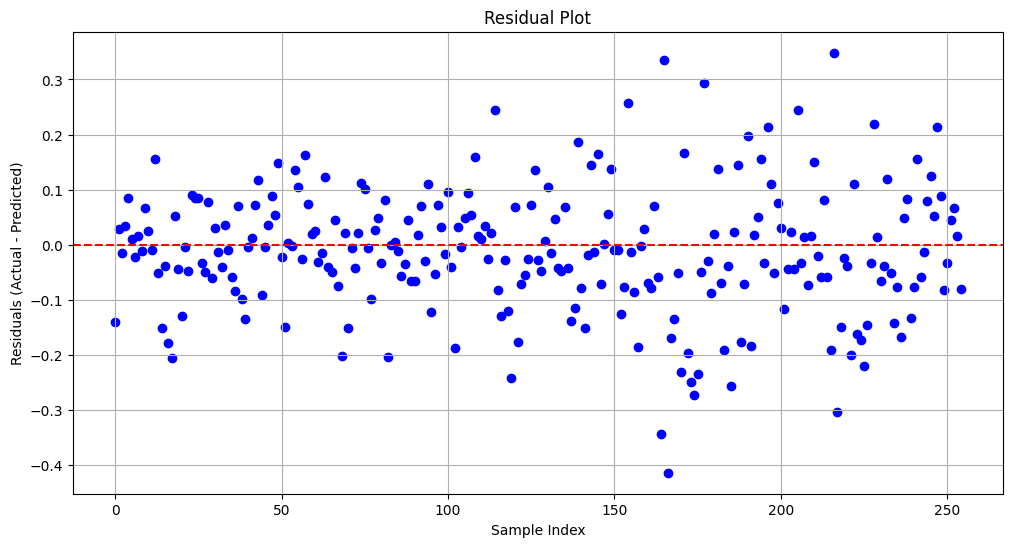

In [70]:
# Calculate residuals
residuals = y_test.flatten() - predictions.flatten()

# Plotting the residuals
plt.figure(figsize=(12, 6))
plt.scatter(range(len(residuals)), residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Sample Index')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)

plt.show()

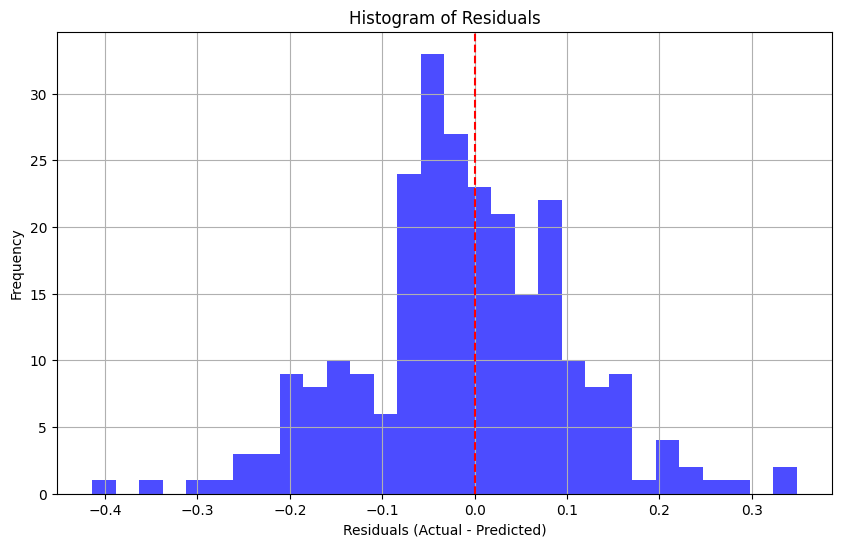

In [71]:
# Plotting the histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='blue', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

In [20]:
# Hyper parameter tuning for LSTM using k fold cross validation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import KFold

def create_model(units, learning_rate, dropout_rate, optimizer_choice):
    model = Sequential([
        LSTM(units, activation='relu', input_shape=(1, X_train.shape[2]), return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units, activation='relu'),
        Dropout(dropout_rate),
        Dense(X_train.shape[2])
    ])

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# ranges for the hyperparameters
units_options = [5, 50]
learning_rates = [0.01, 0.005, 0.001]
dropout_rates = [0.1, 0.2]
batch_sizes = [32, 64]
epochs_options = [50, 100,150]
optimizers = ['adam']

best_score = float('inf')
best_params = {}

kfold = KFold(n_splits=3, shuffle=True, random_state=42)

for units in units_options:
    for lr in learning_rates:
        for dr in dropout_rates:
            for batch_size in batch_sizes:
                for epochs in epochs_options:
                    for optimizer_choice in optimizers:
                        cv_scores = []
                        for train_idx, val_idx in kfold.split(X_train):
                            model = create_model(units=units, learning_rate=lr, dropout_rate=dr, optimizer_choice=optimizer_choice)
                            model.fit(X_train[train_idx], y_train[train_idx], epochs=epochs, batch_size=batch_size, verbose=0)
                            predictions = model.predict(X_train[val_idx])
                            mse = mean_squared_error(y_train[val_idx], predictions)
                            cv_scores.append(mse)
                        average_mse = np.mean(cv_scores)
                        print(f"Units: {units}, LR: {lr}, Dropout: {dr}, Batch Size: {batch_size}, Epochs: {epochs}, Optimizer: {optimizer_choice}, Avg MSE: {average_mse}")
                        if average_mse < best_score:
                            best_score = average_mse
                            best_params = {
                                'units': units,
                                'learning_rate': lr,
                                'dropout_rate': dr,
                                'batch_size': batch_size,
                                'epochs': epochs,
                                'optimizer': optimizer_choice,
                                'mse': average_mse
                            }
print("Best Score (MSE):", best_score)
print("Best Parameters:", best_params)


1/1 [==============================] - 0s 297ms/step
Units: 5, LR: 0.01, Dropout: 0.1, Batch Size: 32, Epochs: 50, Optimizer: adam, Avg MSE: 0.034247730972867915
1/1 [==============================] - 0s 327ms/step
Units: 5, LR: 0.01, Dropout: 0.1, Batch Size: 32, Epochs: 100, Optimizer: adam, Avg MSE: 0.026134657738944023
1/1 [==============================] - 0s 323ms/step
Units: 5, LR: 0.01, Dropout: 0.1, Batch Size: 32, Epochs: 150, Optimizer: adam, Avg MSE: 0.02381553525099987
1/1 [==============================] - 0s 287ms/step
Units: 5, LR: 0.01, Dropout: 0.1, Batch Size: 64, Epochs: 50, Optimizer: adam, Avg MSE: 0.03629470556912017
1/1 [==============================] - 0s 289ms/step
Units: 5, LR: 0.01, Dropout: 0.1, Batch Size: 64, Epochs: 100, Optimizer: adam, Avg MSE: 0.02317656465173946
1/1 [==============================] - 0s 297ms/step
Units: 5, LR: 0.01, Dropout: 0.1, Batch Size: 64, Epochs: 150, Optimizer: adam, Avg MSE: 0.02259201124560641
1/1 [=======================

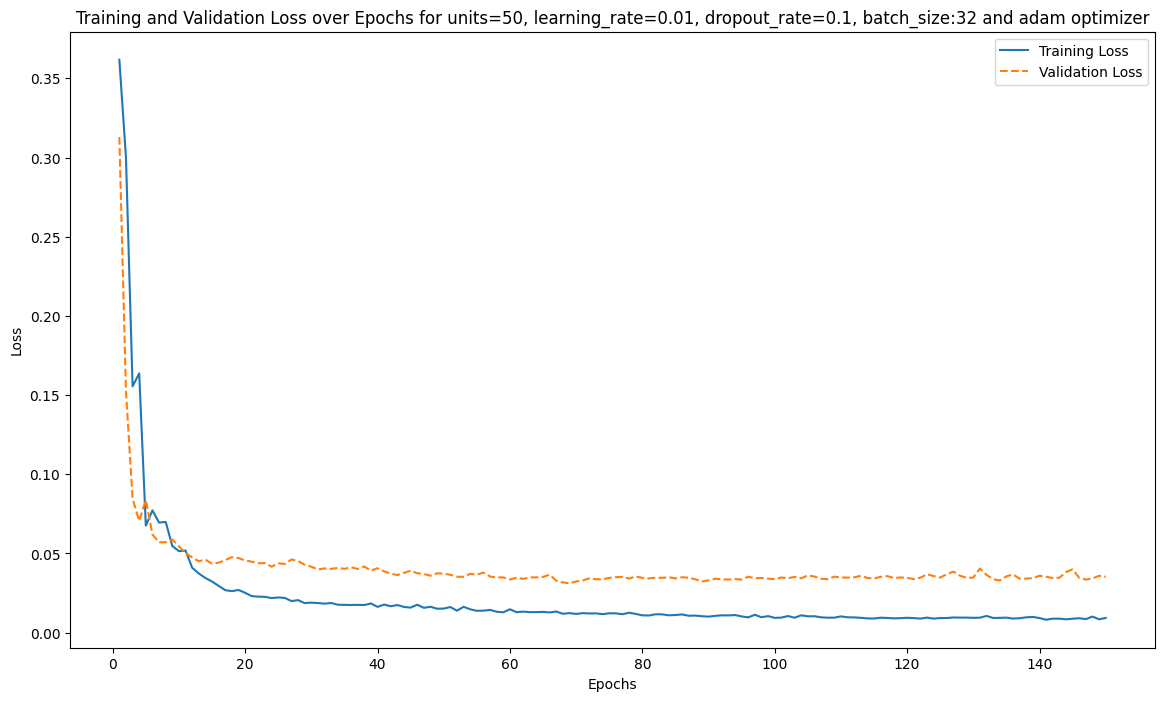

In [73]:
def create_model(units=50, learning_rate=0.01, dropout_rate=0.1):
    model = Sequential([
        LSTM(units, activation='relu', input_shape=(1, X_train.shape[2]), return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units, activation='relu'),
        Dropout(dropout_rate),
        Dense(X_train.shape[2])
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Parameters for the specific configuration
units = 50
learning_rate = 0.01
dropout_rate = 0.1

# Initialize KFold cross-validator
kf = KFold(n_splits=5)

# To store loss for plotting
train_loss_history = []
val_loss_history = []

# Cross-validation
for train_idx, val_idx in kf.split(X_train):
    model = create_model(units=units, learning_rate=learning_rate, dropout_rate=dropout_rate)
    history = model.fit(X_train[train_idx], y_train[train_idx], epochs=150, batch_size=32, verbose=0, validation_data=(X_train[val_idx], y_train[val_idx]))
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

# Average the loss over folds
avg_train_loss = np.mean(train_loss_history, axis=0)
avg_val_loss = np.mean(val_loss_history, axis=0)

# Plotting the training and validation loss
plt.figure(figsize=(14, 8))
plt.plot(range(1, 151), avg_train_loss, label='Training Loss')
plt.plot(range(1, 151), avg_val_loss, linestyle='--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs for units=50, learning_rate=0.01, dropout_rate=0.1, batch_size:32 and adam optimizer')
plt.legend()
plt.show()

####Conv LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense, Flatten


# Assuming 't1' is your DataFrame and has been preprocessed correctly.
train_df = t1_norm[t1_norm['Year'] <= 2016]
test_df = t1_norm[t1_norm['Year'] >= 2017]

# Normalize features
scaler = MinMaxScaler()
features = train_df.columns.difference(['Year'])  # Exclude 'Year'
train_scaled = scaler.fit_transform(train_df[features])
test_scaled = scaler.transform(test_df[features])

X_train = train_scaled.reshape(train_scaled.shape[0], 1, 1, train_scaled.shape[1], 1)
X_test = test_scaled.reshape(test_scaled.shape[0], 1, 1, test_scaled.shape[1], 1)

y_train = train_df[features].values
y_test = test_df[features].values

# Define ConvLSTM model
model = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(1, 2), activation='relu', input_shape=(1, 1, len(features), 1)),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(len(features))
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit model
model.fit(X_train, y_train, epochs=150, verbose=1)

# Predict using the model
predictions = model.predict(X_test)

# Calculate MSE, RMSE, MAE, and R2 for all states combined
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test.flatten(), predictions.flatten())

print(f"MAE: {mae}")
print(f"MSE: {mse}")
#print(f"Aggregated RMSE: {rmse}")
print(f"R2: {r2}")

####XGBOOST

In [ ]:
pip install xgboost

In [ ]:
import xgboost as xgb


train_df = t1_norm[t1_norm['Year'] <= 2015]
test_df = t1_norm[t1_norm['Year'] >= 2016]

# Normalize 
scaler = MinMaxScaler()
features = train_df.columns.difference(['Year'])  
train_features = scaler.fit_transform(train_df[features])
test_features = scaler.transform(test_df[features])

y_train = train_df[features].values
y_test = test_df[features].values

# Train the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(train_features, y_train)

# Predict using the model
predictions = model.predict(test_features)

# Calculate MSE, RMSE, MAE, and R2 for all states combined
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test.flatten(), predictions.flatten())

print(f"Aggregated MAE: {mae}")
print(f"Aggregated MSE: {mse}")
#print(f"Aggregated RMSE: {rmse}")
print(f"Aggregated R2: {r2}")

####Bayes Optimized XGBOOST

In [ ]:
pip install bayesian-optimization

In [ ]:
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization

train_df = t1_norm[t1_norm['Year'] <= 2015]
test_df = t1_norm[t1_norm['Year'] >= 2016]

scaler = MinMaxScaler()
features = train_df.columns.difference(['Year'])  
train_features = scaler.fit_transform(train_df[features])
test_features = scaler.transform(test_df[features])

y_train = train_df[features].values
y_test = test_df[features].values

def xgb_evaluate(max_depth, gamma, colsample_bytree):
    params = {'eval_metric': 'rmse',
              'max_depth': int(max_depth),
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree}
    model = XGBRegressor(**params)
    model.fit(train_features, y_train)
    predictions = model.predict(test_features)
    mse = mean_squared_error(y_test, predictions)
    return -mse  

# Define parameter bounds for Bayesian Optimization
pbounds = {'max_depth': (3, 10),
           'gamma': (0, 5),
           'colsample_bytree': (0.5, 1.0)}

optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds=pbounds,
    random_state=1,
)

# Perform optimization
optimizer.maximize(init_points=3, n_iter=10)

# Print the best parameters found
print(optimizer.max)

# Train final model using the best parameters
params = optimizer.max['params']
params['max_depth'] = int(params['max_depth']) 

final_model = XGBRegressor(**params)
final_model.fit(train_features, y_train)

# Predict using the final model
final_predictions = final_model.predict(test_features)

# Calculate final MSE, RMSE, MAE, and R2
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_test, final_predictions)
final_r2 = r2_score(y_test.flatten(), final_predictions.flatten())

print(f"MAE: {final_mae}")
print(f"MSE: {final_mse}")
#print(f"Final RMSE: {final_rmse}")
print(f"R2: {final_r2}")

####ARIMA

In [ ]:
pip install statsmodels

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

# Initialize lists to store metrics for all states
all_mae, all_mse, all_rmse, all_r2 = [], [], [], []

# Iterate over each state column except 'Year'
for state in t1_norm.columns[1:]:  # Skip 'Year' column
    data = t1_norm[['Year', state]].dropna().set_index('Year')
    train_data = data[data.index <= 2015][state]
    test_data = data[data.index > 2015][state]

    model = ARIMA(train_data, order=(1, 1, 1))
    fitted_model = model.fit()

    # Predict using the model
    predictions = fitted_model.get_forecast(steps=len(test_data))
    prediction_means = predictions.predicted_mean

    # Calculate performance metrics
    mse = mean_squared_error(test_data, prediction_means)
    mae = mean_absolute_error(test_data, prediction_means)
    rmse = sqrt(mse)
    r2 = r2_score(test_data, prediction_means)

    all_mae.append(mae)
    all_mse.append(mse)
    all_rmse.append(rmse)
    all_r2.append(r2)

# Calculate averages of the metrics across all states
avg_mae = np.mean(all_mae)
avg_mse = np.mean(all_mse)
avg_rmse = np.mean(all_rmse)
avg_r2 = np.mean(all_r2)

print(f'MAE: {avg_mae}')
print(f'MSE: {avg_mse}')
#print(f'RMSE: {avg_rmse}')
print(f'R2: {avg_r2}')

In [ ]:
#SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

data = t1_norm.set_index('Year')
data.index = pd.to_datetime(data.index, format='%Y')

# Initialize lists to store metrics for all states
all_mae, all_mse, all_rmse, all_r2 = [], [], [], []

# Define a generic SARIMA model order and seasonal order
# These should ideally be customized based on each state's data characteristics
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # Assuming annual seasonality with period of 12 months

# Iterate over each state column
for state in data.columns[1:]:  # Exclude 'Year' if it's in the columns
    series = data[state].dropna()  # Ensure no NaNs which can affect modeling

    # Split the data
    train_data = series[:'2015']
    test_data = series['2016':]

    if len(train_data) < 5 or len(test_data) < 1:  # Skip if not enough data
        continue

    # Fit the SARIMA model
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    fitted_model = model.fit(disp=False)  # disp=False to avoid convergence messages

    # Predict using the model
    predictions = fitted_model.get_forecast(steps=len(test_data))
    prediction_means = predictions.predicted_mean

    # Calculate performance metrics
    mse = mean_squared_error(test_data, prediction_means)
    mae = mean_absolute_error(test_data, prediction_means)
    rmse = sqrt(mse)
    r2 = r2_score(test_data, prediction_means)

    # Append metrics to lists
    all_mae.append(mae)
    all_mse.append(mse)
    all_rmse.append(rmse)
    all_r2.append(r2)

# Calculate averages of the metrics across all states
avg_mae = np.mean(all_mae)
avg_mse = np.mean(all_mse)
avg_rmse = np.mean(all_rmse)
avg_r2 = np.mean(all_r2)

# Print aggregated metrics
print(f'Aggregated MAE across all states: {avg_mae}')
print(f'Aggregated MSE across all states: {avg_mse}')
print(f'Aggregated RMSE across all states: {avg_rmse}')
print(f'Aggregated R2 across all states: {avg_r2}')


####Prophet

In [ ]:
pip install prophet

In [ ]:
from prophet import Prophet

data = t1_norm.copy()
data['Year'] = pd.to_datetime(data['Year'], format='%Y')  

# Initialize lists to store metrics for all states
all_mae, all_mse, all_rmse, all_r2 = [], [], [], []

for state in data.columns[1:]:  
    df = pd.DataFrame({
        'ds': data['Year'],
        'y': data[state]
    }).dropna()  # Drop NA values to avoid issues during fitting

    train_data = df[df['ds'] <= pd.to_datetime('2015')]
    test_data = df[df['ds'] > pd.to_datetime('2015')]

    m = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
    m.fit(train_data)

    # Make a future dataframe for predictions
    future = m.make_future_dataframe(periods=len(test_data), freq='YS')  
    forecast = m.predict(future)

    # Calculate performance metrics on the test set
    predictions = forecast[-len(test_data):]['yhat']  
    mse = mean_squared_error(test_data['y'], predictions)
    mae = mean_absolute_error(test_data['y'], predictions)
    rmse = sqrt(mse)
    r2 = r2_score(test_data['y'], predictions)

    all_mae.append(mae)
    all_mse.append(mse)
    all_rmse.append(rmse)
    all_r2.append(r2)

avg_mae = np.mean(all_mae)
avg_mse = np.mean(all_mse)
avg_rmse = np.mean(all_rmse)
avg_r2 = np.mean(all_r2)

print(f'Aggregated MAE across all states: {avg_mae}')
print(f'Aggregated MSE across all states: {avg_mse}')
print(f'Aggregated RMSE across all states: {avg_rmse}')
print(f'Aggregated R2 across all states: {avg_r2}')

In [ ]:
# Prophet with cross validation for performance assessment
from prophet.diagnostics import cross_validation, performance_metrics

for state in data.columns[1:]:
    df = pd.DataFrame({
        'ds': data['Year'],
        'y': data[state]
    }).dropna()

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='multiplicative'
    )
    m.add_seasonality(name='yearly', period=365.25, fourier_order=5)  

    train_data = df[df['ds'] <= pd.to_datetime('2015')]
    test_data = df[df['ds'] > pd.to_datetime('2015')]

    m.fit(train_data)

    # Reduced cross-validation complexity
    df_cv = cross_validation(m, initial='1825 days', period='365 days', horizon='180 days')
    df_p = performance_metrics(df_cv)
    print(df_p[['horizon', 'mae', 'mse', 'rmse']])

    future = m.make_future_dataframe(periods=len(test_data), freq='YS')
    forecast = m.predict(future)

    predictions = forecast[-len(test_data):]['yhat']
    mse = mean_squared_error(test_data['y'], predictions)
    mae = mean_absolute_error(test_data['y'], predictions)
    rmse = sqrt(mse)
    r2 = r2_score(test_data['y'], predictions)

    all_mae.append(mae)
    all_mse.append(mse)
    all_rmse.append(rmse)
    all_r2.append(r2)

avg_mae = np.mean(all_mae)
avg_mse = np.mean(all_mse)
avg_rmse = np.mean(all_rmse)
avg_r2 = np.mean(all_r2)

print(f'Aggregated MAE: {avg_mae}')
print(f'Aggregated MSE: {avg_mse}')
print(f'Aggregated RMSE: {avg_rmse}')
print(f'Aggregated R2: {avg_r2}')

##World data- Predicting carbon offset cost using LSTM

In [8]:
import pandas as pd
data = pd.read_csv('data.csv')  
country_data = data[data['country'].isin(['United States', 'India', 'China', 'Russia'])]
last_years_data = country_data.groupby('country')['year'].max()
print(last_years_data)

country
China            2022
India            2022
Russia           2022
United States    2022
Name: year, dtype: int64


In [9]:
country_data

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
8950,China,1850,CHN,409821554.0,3.534960e+11,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8951,China,1851,CHN,407570489.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.668,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN
8952,China,1852,CHN,404611476.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.392,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN
8953,China,1853,CHN,400951224.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.178,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN
8954,China,1854,CHN,397324067.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.931,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45774,United States,2018,USA,332140032.0,1.814065e+13,38.971,0.117,5377.797,165.635,3.178,...,8.143,17.734,0.035,0.226,0.272,0.011,5935.52,6154.65,420.355,7.816
45775,United States,2019,USA,334319680.0,NaN,40.896,0.122,5262.145,-115.652,-2.151,...,8.085,17.599,0.035,0.228,0.275,0.011,5819.48,6039.74,423.539,8.049
45776,United States,2020,USA,335942016.0,NaN,40.688,0.121,4714.628,-547.517,-10.405,...,8.294,17.466,0.035,0.230,0.277,0.011,5289.13,5505.18,471.929,10.010
45777,United States,2021,USA,336997632.0,NaN,41.312,0.123,5032.213,317.585,6.736,...,8.242,17.335,0.035,0.233,0.279,0.011,NaN,NaN,539.960,10.730


In [10]:
# Filter data for the specified countries and relevant columns
filtered_data = data[(data['country'].isin(['United States', 'India', 'Russia', 'China'])) & (data['year'] <= 2023)]
filtered_data = filtered_data[['country', 'year', 'co2']]

# Pivot data to have years as rows and countries as columns
pivoted_data = filtered_data.pivot(index='year', columns='country', values='co2').dropna()

pivoted_data.head(), pivoted_data.tail()

(country   China   India  Russia  United States
 year                                          
 1907     19.894  21.772  56.588       1203.861
 1908     22.736  24.908  56.935       1052.813
 1909     24.252  24.143  60.102       1165.706
 1910     25.009  23.487  58.942       1271.582
 1911     24.631  24.782  61.110       1258.667,
 country      China     India    Russia  United States
 year                                                 
 2018     10353.935  2593.058  1712.494       5377.797
 2019     10721.042  2612.888  1705.031       5262.145
 2020     10914.012  2421.552  1632.929       4714.628
 2021     11336.233  2674.222  1711.993       5032.213
 2022     11396.777  2829.644  1652.177       5057.304)

In [11]:
pivoted_data

country,China,India,Russia,United States
year,,,,
1907,19.894,21.772,56.588,1203.861
1908,22.736,24.908,56.935,1052.813
1909,24.252,24.143,60.102,1165.706
1910,25.009,23.487,58.942,1271.582
1911,24.631,24.782,61.110,1258.667
...,...,...,...,...
2018,10353.935,2593.058,1712.494,5377.797
2019,10721.042,2612.888,1705.031,5262.145
2020,10914.012,2421.552,1632.929,4714.628


In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(pivoted_data)

# Convert scaled_data back to DataFrame
scaled_data_df = pd.DataFrame(scaled_data, columns=pivoted_data.columns, index=pivoted_data.index)

scaled_data_df

country,China,India,Russia,United States
year,,,,
1907,0.000252,0.000000,0.014940,0.029738
1908,0.000502,0.001117,0.015077,0.000000
1909,0.000635,0.000844,0.016336,0.022226
1910,0.000701,0.000611,0.015875,0.043070
1911,0.000668,0.001072,0.016736,0.040527
...,...,...,...,...
2018,0.908360,0.915742,0.672759,0.851480
2019,0.940620,0.922804,0.669794,0.828711
2020,0.957577,0.854661,0.641151,0.720919


In [13]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

n_steps = 3
X, y = create_sequences(scaled_data, n_steps)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, scaled_data.shape[1])),
    Dense(scaled_data.shape[1])
])
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
# Assuming using the last few (e.g., last 5 years) as validation data
X_train, X_val = X[:-5], X[-5:]
y_train, y_val = y[:-5], y[-5:]

model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
4/4 [==============================] - 5s 290ms/step - loss: 0.2287 - val_loss: 0.8075
Epoch 2/50
4/4 [==============================] - 0s 27ms/step - loss: 0.2109 - val_loss: 0.7505
Epoch 3/50
4/4 [==============================] - 0s 46ms/step - loss: 0.1950 - val_loss: 0.6947
Epoch 4/50
4/4 [==============================] - 0s 27ms/step - loss: 0.1791 - val_loss: 0.6403
Epoch 5/50
4/4 [==============================] - 0s 25ms/step - loss: 0.1638 - val_loss: 0.5847
Epoch 6/50
4/4 [==============================] - 0s 17ms/step - loss: 0.1475 - val_loss: 0.5262
Epoch 7/50
4/4 [==============================] - 0s 25ms/step - loss: 0.1318 - val_loss: 0.4644
Epoch 8/50
4/4 [==============================] - 0s 24ms/step - loss: 0.1138 - val_loss: 0.4022
Epoch 9/50
4/4 [==============================] - 0s 19ms/step - loss: 0.0954 - val_loss: 0.3416
Epoch 10/50
4/4 [==============================] - 0s 19ms/step - loss: 0.0773 - val_loss: 0.2784
Epoch 11/50
4/4 [===========

In [19]:
# Adjust the future_steps to predict for four years 
future_steps = 4
last_sequence = scaled_data[-n_steps:]
current_sequence = last_sequence.reshape(1, n_steps, scaled_data.shape[1])

predictions = []
for _ in range(future_steps):
    next_year_pred = model.predict(current_sequence)[0]
    predictions.append(next_year_pred)
    next_year_pred = next_year_pred.reshape(1, 1, scaled_data.shape[1])
    current_sequence = np.append(current_sequence[:, 1:, :], next_year_pred, axis=1)

predictions_actual = scaler.inverse_transform(predictions)

years = [2023, 2024, 2025, 2026]
countries = ['China', 'India', 'Russia', 'United States']

# Convert predictions to a DataFrame for better readability
predictions_df = pd.DataFrame(predictions_actual, index=years, columns=countries)

print(predictions_df)

1/1 [==============================] - 0s 52ms/step
             China        India       Russia  United States
2023  12801.981769  2759.137647  1319.537702    5741.610301
2024  13639.473501  2948.960873  1308.035273    5906.638200
2025  14230.176358  3085.283421  1234.989933    5928.826439
2026  14878.472465  3241.253288  1146.141995    5927.738038


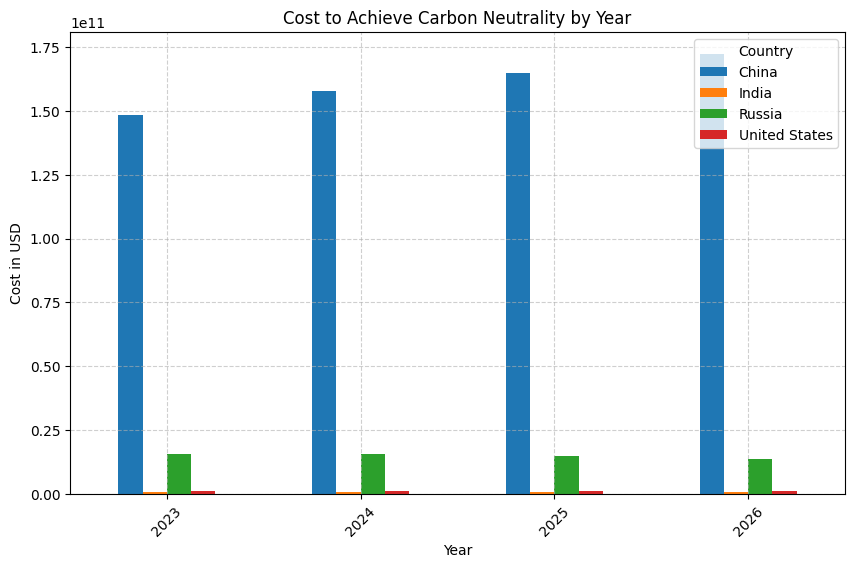

In [20]:
# Define the carbon credit costs per ton for each country (USD per metric ton)
carbon_credit_costs = pd.Series({
    'China': 11.58,    # USD per metric ton
    'India': 0.214,    
    'Russia': 12,      
    'United States': 0.214  
}, name='Cost per Ton')

# Calculate  excess emissions
target_emissions = 0  
excess_emissions = predictions_df - target_emissions

# Multiply by 1,000,000 to convert million metric tons to metric tons
costs_to_neutralize = excess_emissions.mul(carbon_credit_costs, axis=1) * 1e6  

# Plotting
costs_to_neutralize.plot(kind='bar', figsize=(10, 6))
plt.title('Cost to Achieve Carbon Neutrality by Year')
plt.ylabel('Cost in USD')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.legend(title='Country')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [21]:
costs_to_neutralize

,China,India,Russia,United States
2023,1.482469e+11,5.904555e+08,1.583445e+10,1.228705e+09
2024,1.579451e+11,6.310776e+08,1.569642e+10,1.264021e+09
2025,1.647854e+11,6.602507e+08,1.481988e+10,1.268769e+09
2026,1.722927e+11,6.936282e+08,1.375370e+10,1.268536e+09
